# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from tabulate import tabulate

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [3]:
# !pip install -U scikit-learn
# !pip install pandas-profiling==2.7.1

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [5]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [6]:
data
data_tr = data.copy()

In [7]:
# Профилируем датасет для получения общей картины
# ProfileReport(data)

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
# Cоотношение мужчин и женщин в датасете
print(data_tr['Sex'].value_counts(),'\n')
print(data_tr['Sex'].value_counts() / data['Sex'].value_counts().sum())

male      577
female    314
Name: Sex, dtype: int64 

male      0.647587
female    0.352413
Name: Sex, dtype: float64


In [9]:
# Количество выживших пассажиров
data_tr['Survived'].sum()

342

In [10]:
# Cоотношение мужчин и женщин среди выживших
print(data_tr[data_tr['Survived'] == 1]['Sex'].value_counts(), '\n')
print(data_tr[data_tr['Survived'] == 1]['Sex'].value_counts() / data_tr[data_tr['Survived'] == 1]['Sex'].value_counts().sum())

female    233
male      109
Name: Sex, dtype: int64 

female    0.681287
male      0.318713
Name: Sex, dtype: float64


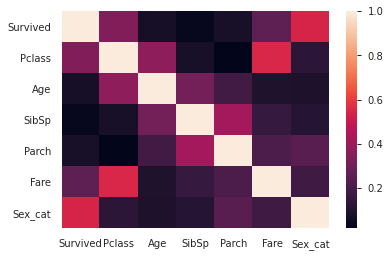

In [11]:
# Переводим признак Sex в категорийный и строим тепловую карту, используя корреляцию Пирсона

data_tr['Sex_cat'], _ = data_tr['Sex'].factorize()
sns.heatmap(data_tr.corr().abs());

# Вывод: 
### Из тепловой карты видно, что существует довольно высокая корреляция между признаками Sex_cat и Survived.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

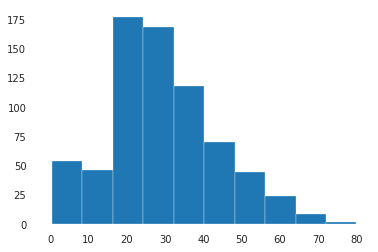

In [12]:
# Распределение пассажиров по возрастам
plt.hist(data_tr['Age']);

In [13]:
surv_age_mean = data_tr[data_tr['Survived'] == 1]['Age'].mean()
surv_age_median = data_tr[data_tr['Survived'] == 1]['Age'].median()
dec_age_mean = data_tr[data_tr['Survived'] == 0]['Age'].mean()
dec_age_median = data_tr[data_tr['Survived'] == 0]['Age'].median()
print(tabulate([('Average', surv_age_mean, dec_age_mean), ('Median', surv_age_median, dec_age_median)],
               headers=('Age', 'Survived', 'Deceased')))


Age        Survived    Deceased
-------  ----------  ----------
Average     28.3437     30.6262
Median      28          28


## Вывод:
### Средний возраст выживших меньше, чем умерших, что объясняется более высокой активностью и выносливостью молодых пассажиров.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [14]:
print('Процент выживших в разрезе класса:\n')
out = []
for cls in range(1, 4):
  out.append(data_tr[data_tr['Pclass'] == cls]['Survived'].mean())
print(out)

Процент выживших в разрезе класса:

[0.6296296296296297, 0.47282608695652173, 0.24236252545824846]


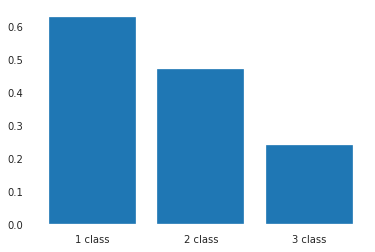

In [15]:
plt.bar(['1 class', '2 class', '3 class'], out);

## Вывод:
### Наиболее безопасным, как и ожидалось, оказался первый класс, пассажиры которого в первую очередь обеспечивались средствами спасения.

              Embarked_cat  Survived
Embarked_cat      1.000000  0.101849
Survived          0.101849  1.000000


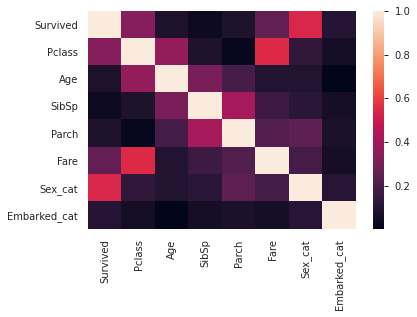

In [16]:
#Переводим признак Embarked в категорийный и строим тепловую карту, используя корреляцию Пирсона
data_tr['Embarked_cat'], _ = data_tr['Embarked'].factorize()
print(data_tr[['Embarked_cat', 'Survived']].corr())
sns.heatmap(data_tr.corr().abs());

## Вывод:
### Из тепловой карты видно, что порт посадки очень слабо влияет на выживаемость пассажиров.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [17]:
data_tr.isna().mean()

Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.198653
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin           0.771044
Embarked        0.002245
Sex_cat         0.000000
Embarked_cat    0.000000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

## Отсутствующие значения в датасете можно заменить следующим образом:


*   Age - на медиану возраста.
*   Cabin - считаю, что данный признак можно вообще удалить из датасета как несущественный.
*   Embarked - на постоянное значение, например, 'S'


---






**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [18]:
def proc(df):
  df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
  df['Age'].fillna(df['Age'].median(), inplace=True)
  df['Embarked'].fillna('S', inplace=True)
  df['Embarked'], _ = df['Embarked'].factorize()
  df['Fare'].fillna(df['Fare'].mean(), inplace=True)
  df['Sex'], _ = df['Sex'].factorize()
  df.dropna(inplace=True)
  return df

X = proc(data.copy())
y = X.pop('Survived')
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [19]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8059701492537313

In [20]:
# LogisticRegression + CV
lr = LogisticRegressionCV(random_state=42, max_iter=500)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8059701492537313

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [21]:

# Соединяем train и test датасеты для увеличения выборки
td = pd.concat([data.copy(), data_test.copy()], ignore_index=False, sort=False)

In [22]:
# Добавляем признак количества родственников
td['Family'] = td['Parch'] + td['SibSp']

# Заполняем пропущенный тариф 
td['Fare'].fillna(td['Fare'].median(), inplace=True)

# Создаем новый признак из имени  и кодируем его
td['Salutation'] = td['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
td = pd.concat([td, pd.get_dummies(td['Salutation'], prefix="Salut")], axis=1)

# Заполняем пропущенные значения возраста медианой по группе Пол+Класс
grp = td.groupby(['Sex', 'Pclass'])
td['Age'] = grp['Age'].apply(lambda x: x.fillna(x.median()))
td['Age'].fillna(td['Age'].median(), inplace=True)

# Кодируем признак Sex
td['Sex'], _ = td['Sex'].factorize()

# Удаляем лишние признаки
td.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Salutation'], axis=1, inplace=True )

In [23]:
# Разбиваем датасет на 2 части (train и test) как в исходной выборке
data_p, data_train_p = td.iloc[:891], td.iloc[891:].drop('Survived', axis=1)

In [24]:
X = data_p.copy()
y = X.pop('Survived')
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)

In [25]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8246268656716418

In [26]:
# LogisticRegression + CV
lr = LogisticRegressionCV(random_state=42, max_iter=500)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8283582089552238

In [27]:
# Grid Search + CV
np.random.seed(50)
logistic = LogisticRegression(solver='liblinear', max_iter=500)
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 100)
hyperparameters = dict(C=C, penalty=penalty)
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)
best_model = gridsearch.fit(X_test, y_test)
print(best_model.best_estimator_.get_params()['penalty'])
print(best_model.best_estimator_.get_params()['C'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
l1
1555.6761439304723


In [28]:
best_model.score(X_test, y_test)

0.8544776119402985

In [29]:
cross_val_score(best_model, X_test, y_test, cv=3, n_jobs=-1)

array([0.83333333, 0.84269663, 0.84269663])

In [30]:
X_ts = data_train_p
y_ts = best_model.predict(X_ts).astype(int)

pd.DataFrame([np.arange(892, 1310), y_ts]).transpose().to_csv('submit.csv', index=False, header=['PassengerId','Survived'])


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
## your code

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code